# Initialize notebook

In [3]:
import os
from os import path
import numpy as np
import time
import ImagePipeline_utils as IP
from ImagePipeline_utils import timing, suppress_stdout


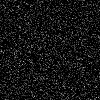

In [12]:
#testing addnoise method
import PIL
new_im = PIL.Image.new(size = (100,100), mode = 'L')
IP.addnoise(new_im, 50)


In [2]:
base_dir = '/home/mickael.tits/image-restoration-github'



#in google colab, simply use:
#base_dir = '/content'

os.chdir(base_dir)

input_dir = path.join(base_dir, 'MyImages')
output_dir = path.join(base_dir, 'MyResults')

if not path.exists(input_dir):
    os.makedirs(input_dir)
    
if not path.exists(output_dir):
    os.makedirs(output_dir)

#needed to use the right python interpreter when calling command line from jupyter (there should be a better solution but I did not figure it yet)
python_dir = '/home/mickael.tits/miniconda/envs/imagepipeline/bin/python'
#in colab, simply use:
#python_dir = 'python'


# Prepare inputs/outputs

In [ ]:
# Create or reset input directory

!rm -r {input_dir}
!mkdir {input_dir}


In [ ]:

!rm -r {output_dir}
!mkdir {output_dir}

# Preprocess photos

In [3]:
# Check if thare are images in input_dir

if not os.listdir(input_dir):
    raise Exception("Input directory is empty. No images to process.")
    

In [4]:

#grayscale needed for NLRN (it takes only one channel)
convert_to_grayscale = True
resize_images = True
size = 1000,1000
    
IP.preprocess(input_dir, size=size, gray = convert_to_grayscale, resize = resize_images)


cannot identify image file '/home/mickael.tits/image-restoration-github/MyImages/Thumbs.db'


# Denoising - NLRN

In [5]:

dn_input_dir = input_dir

dn_method = 'NLRN'

#dn_working_dir = path.join(base_dir,dn_method)
dn_output_dir = path.join(output_dir, dn_method)

os.chdir(base_dir)

!rm -r {dn_input_dir}'/.ipynb_checkpoints'
!mkdir {dn_output_dir}

!{python_dir} denoiser.py -i {dn_input_dir} -o {dn_output_dir}

#!{python_dir} {base_dir}'/denoiser_NLRN_DNCNN.py' --method 'NLRN' --input-dir {dn_input_dir} --output-dir {dn_output_dir}



rm: cannot remove '/home/mickael.tits/image-restoration-github/MyImages/.ipynb_checkpoints': No such file or directory
2019-09-16 08:15:41.288462: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2019-09-16 08:15:41.809503: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2000125000 Hz
2019-09-16 08:15:41.832720: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55fc5bc38e80 executing computations on platform Host. Devices:
2019-09-16 08:15:41.832812: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-09-16 08:15:42.888222: E tensorflow/stream_executor/cuda/cuda_driver.cc:300] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2019-09-16 08:15:42.888283: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:161] retrieving CUDA diagnostic inf

In [7]:
import subprocess

command = python_dir + ' denoiser.py -i ' + dn_input_dir + ' -o ' + dn_output_dir
proc = subprocess.call(command, shell=True)

#!{python_dir} denoiser.py -i {dn_input_dir} -o {dn_output_dir}

KeyboardInterrupt: 

# Colorization - NoGAN (DeOldify)

In [7]:

col_input_dir = dn_output_dir
#col_working_dir = path.join(base_dir, 'DeOldify')
col_output_dir = path.join(output_dir, 'DeOldify')

!mkdir {col_output_dir}

os.chdir(base_dir)

!{python_dir} colorizer.py -i {col_input_dir} -o {col_output_dir}


mkdir: cannot create directory ‘/home/mickael.tits/image-restoration/MyResults/DeOldify’: File exists
/home/mickael.tits/miniconda/envs/imagepipeline/lib/python3.6/site-packages/fastai/data_block.py:451: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/home/mickael.tits/miniconda/envs/imagepipeline/lib/python3.6/site-packages/fastai/data_block.py:454: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")
1. CETIC 2 (887).png: finished in 8.0966 s
Colorization: finished in 8.0967 s


# Super-resolution - ESRGAN

In [22]:

sr_input_dir = col_output_dir

sr_output_dir = path.join(output_dir, 'ESRGAN_PSNR')

!mkdir {sr_output_dir}

os.chdir(base_dir)

!{python_dir} superresolution.py -i {sr_input_dir} -o {sr_output_dir} -a 'PSNR'
#-a 'PSNR'



Model path ./ESRGAN/models/RRDB_PSNR_x4.pth. 
Testing...
1 CETIC 2 (887)
super-resolution: finished in 2.1117 s


# Finalization

In [ ]:
%cd {base_dir}
!zip -r outputs.zip {output_dir}
!zip -r final.zip {sr_output_dir}

# Experimental: image enhancement (calling other conda environment)

In [26]:
python_dir2 = '/home/mickael.tits/miniconda/envs/dpenhance/bin/python'
base_dir = '/home/mickael.tits/Deep-Photo-Enhance/'

working_dir = base_dir + 'LPGAN_exp_G3_999/'

%cd {working_dir}

script_path = os.path.join(working_dir ,'deep-photo-enhancer.py' )

model_dir =  os.path.join(base_dir, 'LPGAN_exp_G3_999/', 'model/90.000-new.ckpt')

enh_input_dir = col_output_dir

enh_output_dir =  os.path.join(base_dir, 'MyResults/')

!mkdir enh_output_dir

!{python_dir2} {script_path} --model-path {model_dir} --input-dir {enh_input_dir} --output-dir {enh_output_dir}

/home/mickael.tits/Deep-Photo-Enhance/LPGAN_exp_G3_999
mkdir: cannot create directory ‘enh_output_dir’: File exists
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcublas.so locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcudnn.so locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcufft.so locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcuda.so.1 locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcurand.so locally
I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I tensorflow/core/common_runtime/gpu/gpu_device.cc:885] Found device 0 with properties: 
name: Tesla T4
major: 7 minor: 5 memoryClockRate (GHz) 1.59
pciBusID 0000:00:04.0
Total memory: